# Hybrid multivariate distribution estimation  
This study aims at building a multivariate joint distribution presenting a complex dependence structure. 

Using non-parametric dependency estimation (Bernstein copula) and both parametric and non-parametric (kde) marginal estimation.

In [1]:
%matplotlib inline

In [2]:
from matplotlib import rc, rcParams, style
#style.use('default')
rcParams['text.usetex'] = True
#rcParams['text.latex.unicode'] = True
rc('font', **{'family': 'Times'})
rc('text', usetex=True)
rc('font', size=18)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=18)# Set the axes labels font size
rc('xtick', labelsize=18)# Set the font size for x tick labels
rc('ytick', labelsize=18)# Set the font size for y tick labels
rc('legend', fontsize=18)# Set the legend font size

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import openturns as ot
import openturns.viewer as viewer
import matplotlib.pyplot as plt

In [4]:
df_processed = pd.read_csv('data/df_ANEMOC_1H.csv')
all_indexes = df_processed.index.values
saved_colomns = ['θ_wind (deg)', 'U_hub (m/s)', 'θ_wave_new (deg)', 'Hs (m)', 'Tp (s)']
df = df_processed.loc[:, saved_colomns]
new_columns = ["$\\theta_{wind}$", "$U$", "$\\theta_{wave}$", "$H_s$", "$T_p$"]
df.columns = new_columns

In [5]:
len(all_indexes) / 32

8766.0

## SCADA environmental data

In [6]:
# Monte Carlo sub-sample to make the plots and the fits faster
N = 10000
N = len(all_indexes)
np.random.seed(1236)
candidates_indexes = np.random.choice(all_indexes, N, replace=False)
df_candidates = df.loc[candidates_indexes, new_columns]
df_candidates_physical = df.loc[candidates_indexes, new_columns]

In [7]:
#g = sns.PairGrid(df, corner=True, hue_kws={"alpha": [0.002], "marker": ["."]})
#g = g.map_diag(sns.histplot, bins=20, color='C3')
#g = g.map_lower(plt.scatter, color='C3')
#g.savefig('figures/subsambled_data.jpg');

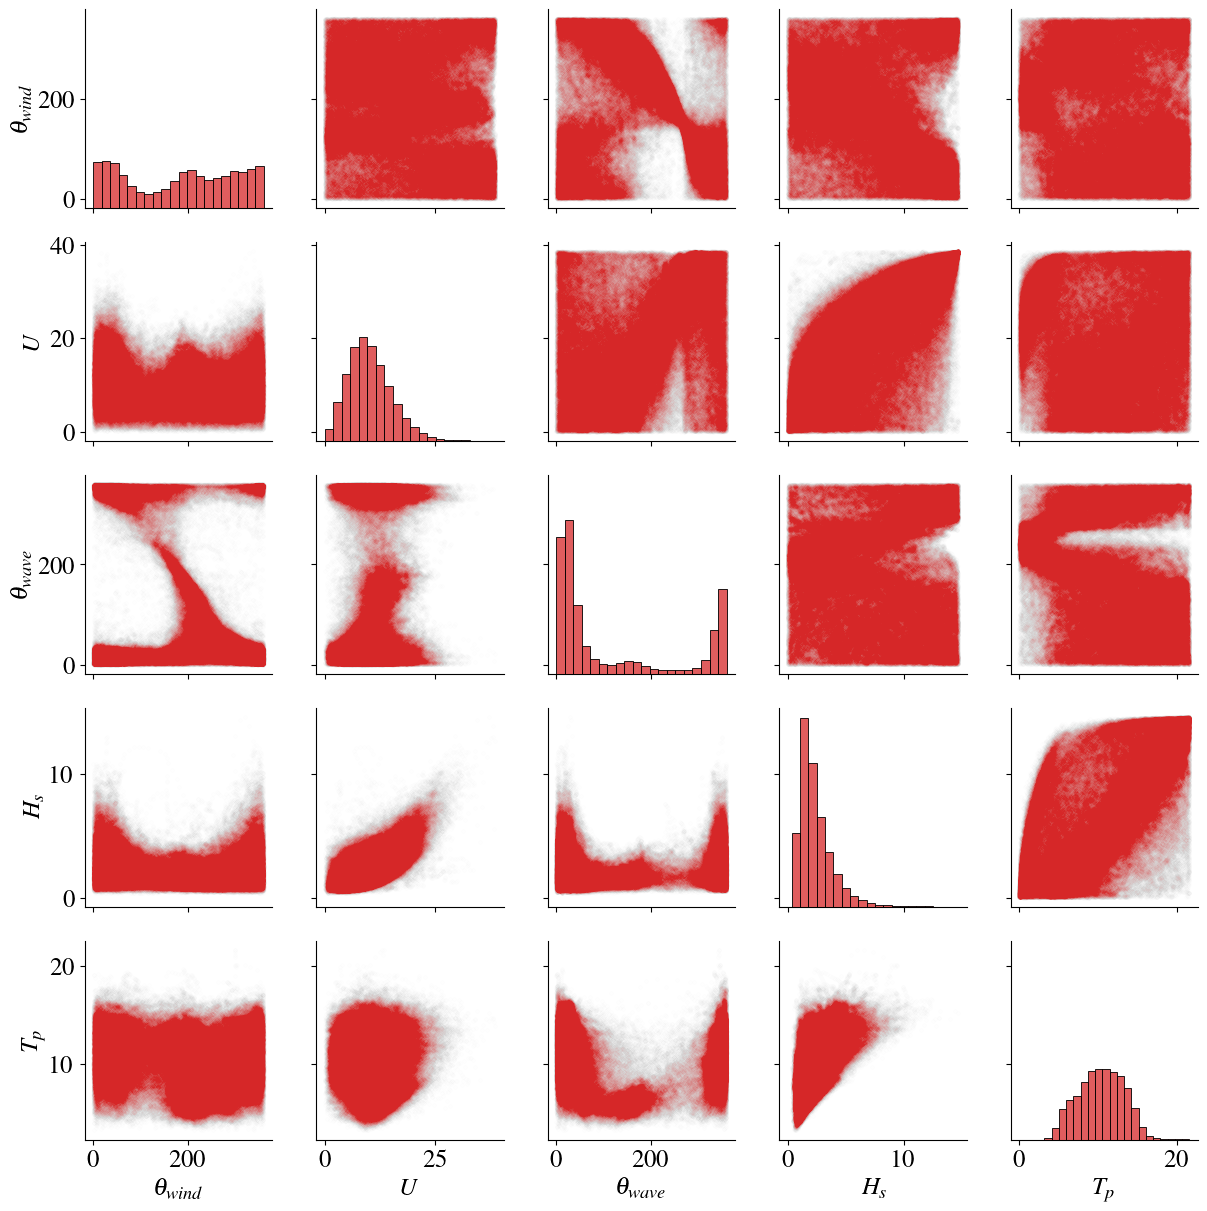

In [8]:
alpha = 0.005
#rasterized=True is not speeding up plots
g = sns.PairGrid(df_candidates , hue_kws={"alpha": [alpha], "marker": ["."]})
g = g.map_diag(sns.histplot, bins=20, color='C3')
g = g.map_lower(plt.scatter, color='C3')

g.data = df_candidates.rank() / N * df_candidates.max().values
g = g.map_upper(plt.scatter, color='C3')
g.savefig('figures/subsambled_data.jpg', dpi=300);

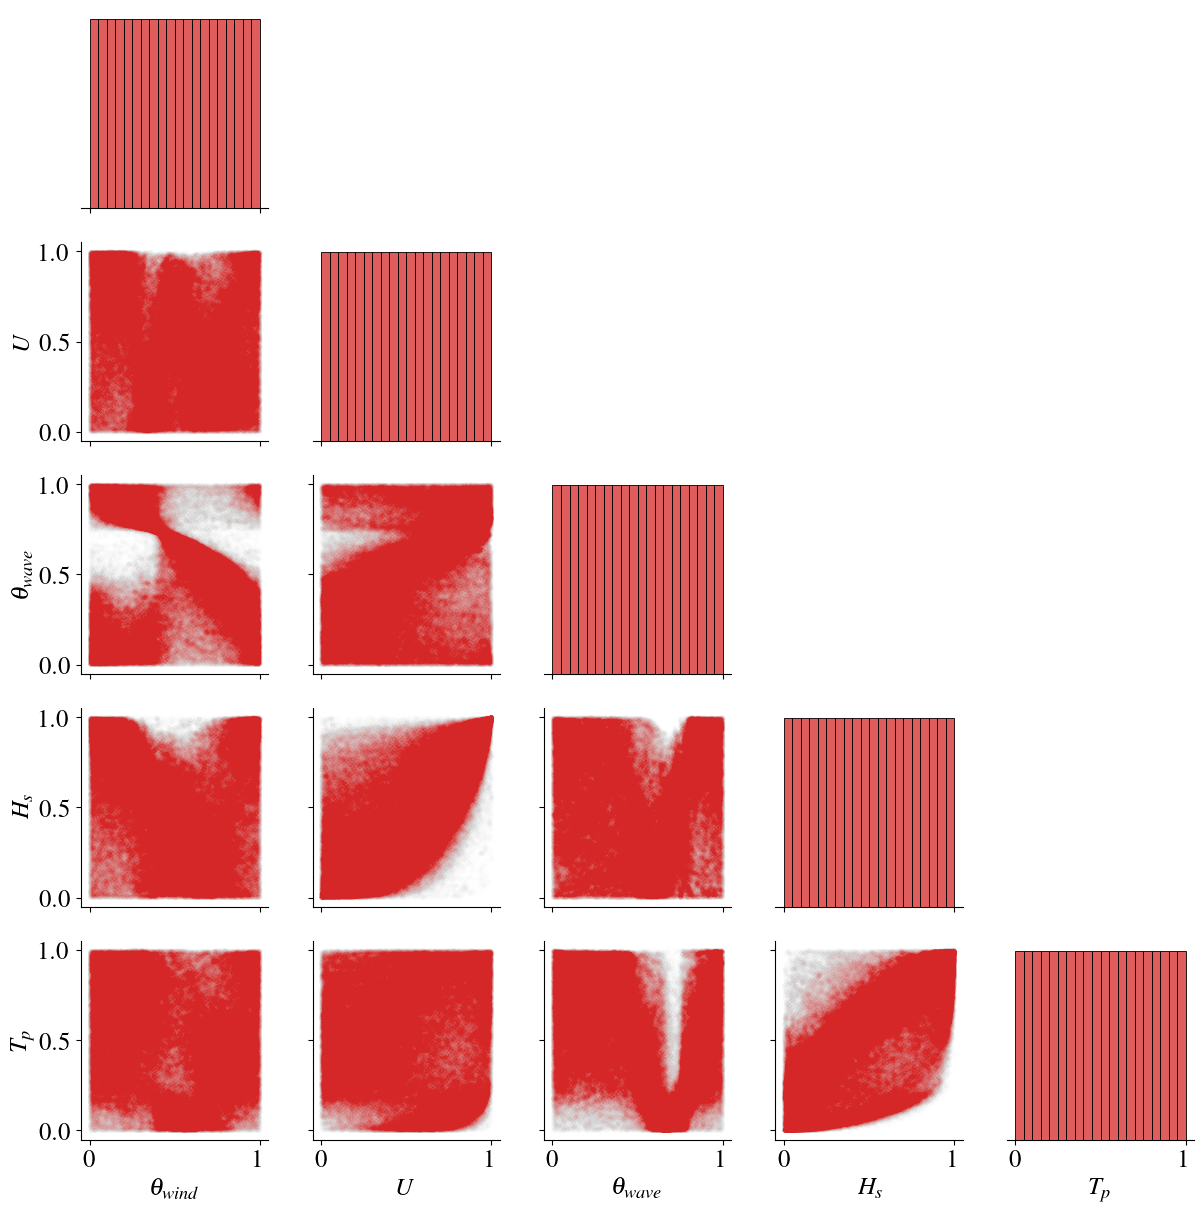

In [9]:
g = sns.PairGrid(df_candidates.rank() / N, corner=True, hue_kws={"alpha": [alpha], "marker": ["."]})
g = g.map_diag(sns.histplot, bins=20, color='C3')
g = g.map_lower(plt.scatter, color='C3')
g.savefig('figures/ranked_subsambled_data.jpg', dpi=300);

## Marginals estimation

WeibullMin(beta = 11.4805, alpha = 2.21887, gamma = 0.00222247)


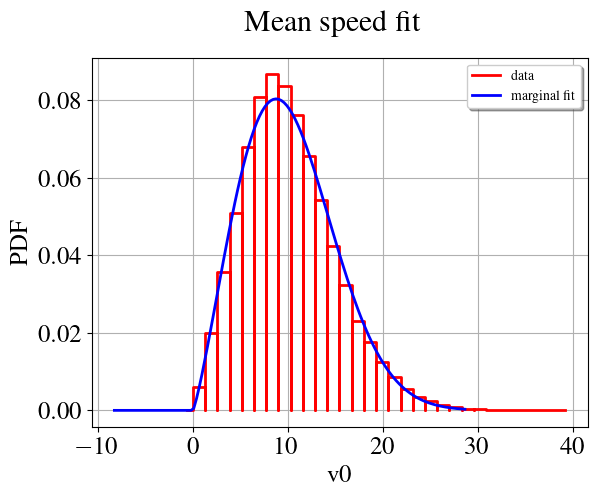

In [10]:
U_data = ot.Sample(df_candidates["$U$"].values.reshape(-1, 1))
U_dist = ot.WeibullMinFactory().build(U_data)
print(U_dist)
# Visual check 
histo = ot.HistogramFactory().build(U_data, 30).drawPDF()
histo.setTitle("Mean speed fit")
histo.add(U_dist.drawPDF())
histo.setLegends(['data', 'marginal fit'])
histo.setColors(['red', 'blue'])
view = viewer.View(histo)

In [11]:
df_candidates.columns

Index(['$\theta_{wind}$', '$U$', '$\theta_{wave}$', '$H_s$', '$T_p$'], dtype='object')

WeibullMin(beta = 2.24893, alpha = 1.57753, gamma = 0.33672)


WRN - Switch to finite difference to compute the gradient at point=[-3.54227,74.3076,0.337289]
WRN - TNC went to an abnormal point x=[nan,nan,nan] y=[] msg=TNC got a nan input value


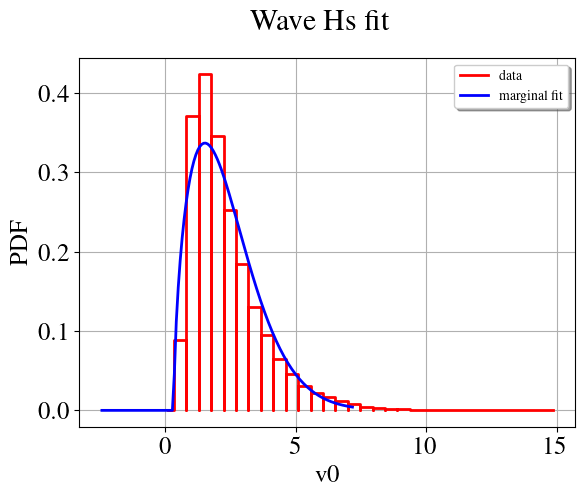

In [12]:
Hs_data = ot.Sample(df_candidates["$H_s$"].values.reshape(-1, 1))
Hs_dist = ot.WeibullMinFactory().build(Hs_data)
print(Hs_dist)
# Visual check 
histo = ot.HistogramFactory().build(Hs_data, 30).drawPDF()
histo.setTitle("Wave Hs fit")
histo.add(Hs_dist.drawPDF())
histo.setLegends(['data', 'marginal fit'])
histo.setColors(['red', 'blue'])
view = viewer.View(histo)

Silverman bandwidth = 0.25


WRN - Warning! The distribution number 1 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=6.95082e-10 with respect to the maximum weight=695.082. It is removed from the collection.
WRN - Warning! The distribution number 848 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=6.95082e-10 with respect to the maximum weight=695.082. It is removed from the collection.
WRN - Warning! The distribution number 891 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=6.95082e-10 with respect to the maximum weight=695.082. It is removed from the collection.
WRN - Warning! The distribution number 892 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=6.95082e-10 with respect to the maximum weight=695.082. It is removed from the collection.
WRN - Warning! The distribution number 893 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=6.95082e-10 with respect to 

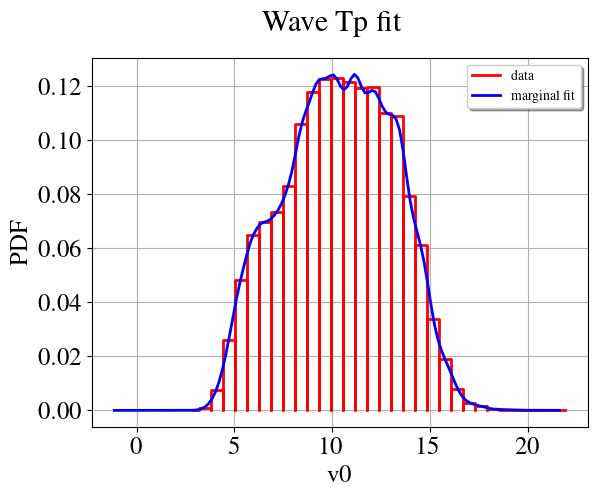

In [13]:
Tp_data = ot.Sample(df_candidates["$T_p$"].values.reshape(-1, 1))
#Tp_dist = ot.LogNormalFactory().build(Tp_data)
kernel = ot.KernelSmoothing()
# Different bandwidth computation 
# (see: http://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_estimate_non_parametric_distribution.html)
silverman_kw = kernel.computeSilvermanBandwidth(Tp_data)
#mixed_kw = kernel.computeMixedBandwidth(Tp_data)
#plugin_kw = kernel.computePluginBandwidth(Tp_data)
print("Silverman bandwidth = {:.2f}".format(silverman_kw[0]))
#print("Mixed bandwidth = {:.2f}".format(mixed_kw[0]))
#print("Plugin bandwidth = {:.2f}".format(plugin_kw[0]))
Tp_kde = kernel.build(Tp_data, silverman_kw)
# Visual check 
histo = ot.HistogramFactory().build(Tp_data, 30).drawPDF()
histo.setTitle("Wave Tp fit")
histo.add(Tp_kde.drawPDF())
histo.setLegends(['data', 'marginal fit'])
histo.setColors(['red', 'blue'])
view = viewer.View(histo)

Mixed bandwidth = 2.80


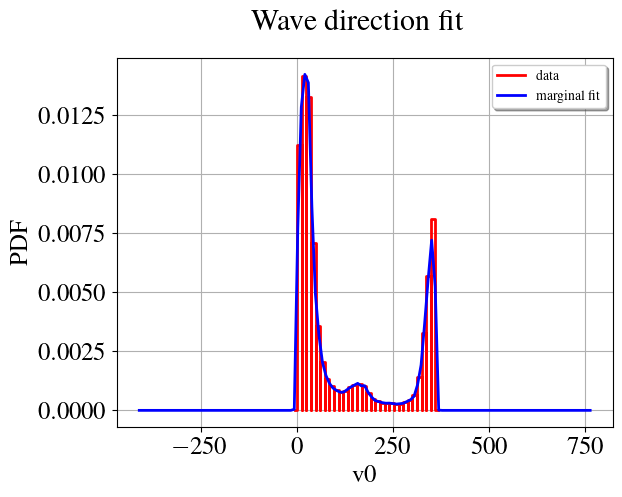

In [14]:
WaveDir_data = ot.Sample(df_candidates["$\\theta_{wave}$"].values.reshape(-1, 1))
#WaveDir_dist = ot.WeibullMinFactory().build(WaveDir_data)
kernel = ot.KernelSmoothing()
# Different bandwidth computation 
#silverman_kw = kernel.computeSilvermanBandwidth(WaveDir_data)
mixed_kw = kernel.computeMixedBandwidth(WaveDir_data)
#plugin_kw = kernel.computePluginBandwidth(WaveDir_data)
#print("Silverman bandwidth = {:.2f}".format(silverman_kw[0]))
print("Mixed bandwidth = {:.2f}".format(mixed_kw[0]))
#print("Plugin bandwidth = {:.2f}".format(plugin_kw[0]))
WaveDir_kde = kernel.build(WaveDir_data, mixed_kw)
# Visual check 
histo = ot.HistogramFactory().build(WaveDir_data, 30).drawPDF()
histo.setTitle("Wave direction fit")
histo.add(WaveDir_kde.drawPDF())
histo.setLegends(['data', 'marginal fit'])
histo.setColors(['red', 'blue'])
view = viewer.View(histo)

Mixed bandwidth = 4.24


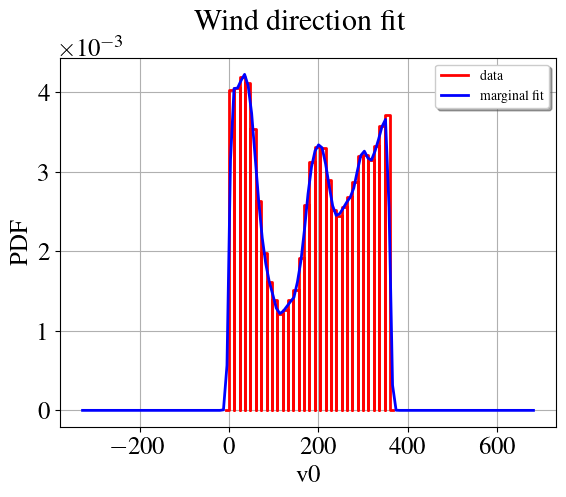

In [15]:
WindDir_data = ot.Sample(df_candidates["$\\theta_{wind}$"].values.reshape(-1, 1))
#WindDir_dist = ot.WeibullMinFactory().build(WindDir_data)
kernel = ot.KernelSmoothing()
# Different bandwidth computation 
#silverman_kw = kernel.computeSilvermanBandwidth(WindDir_data)
mixed_kw = kernel.computeMixedBandwidth(WindDir_data)
#plugin_kw = kernel.computePluginBandwidth(WindDir_data)
#print("Silverman bandwidth = {:.2f}".format(silverman_kw[0]))
print("Mixed bandwidth = {:.2f}".format(mixed_kw[0]))
#print("Plugin bandwidth = {:.2f}".format(plugin_kw[0]))
WindDir_kde = kernel.build(WindDir_data, mixed_kw)
# Visual check 
histo = ot.HistogramFactory().build(WindDir_data, 30).drawPDF()
histo.setTitle("Wind direction fit")
histo.add(WindDir_kde.drawPDF())
histo.setLegends(['data', 'marginal fit'])
histo.setColors(['red', 'blue'])
view = viewer.View(histo)

## Bernstein copula estimation

In [16]:
K = 100
sample = ot.Sample(df_candidates[new_columns].values)
#ot.BernsteinCopulaFactory().ComputeAMISEBinNumber(sample)
bernstein_copula = ot.BernsteinCopulaFactory().build(sample, K)

In [17]:
berstein_sample = pd.DataFrame(np.array(bernstein_copula.getSample(N)), columns=new_columns)

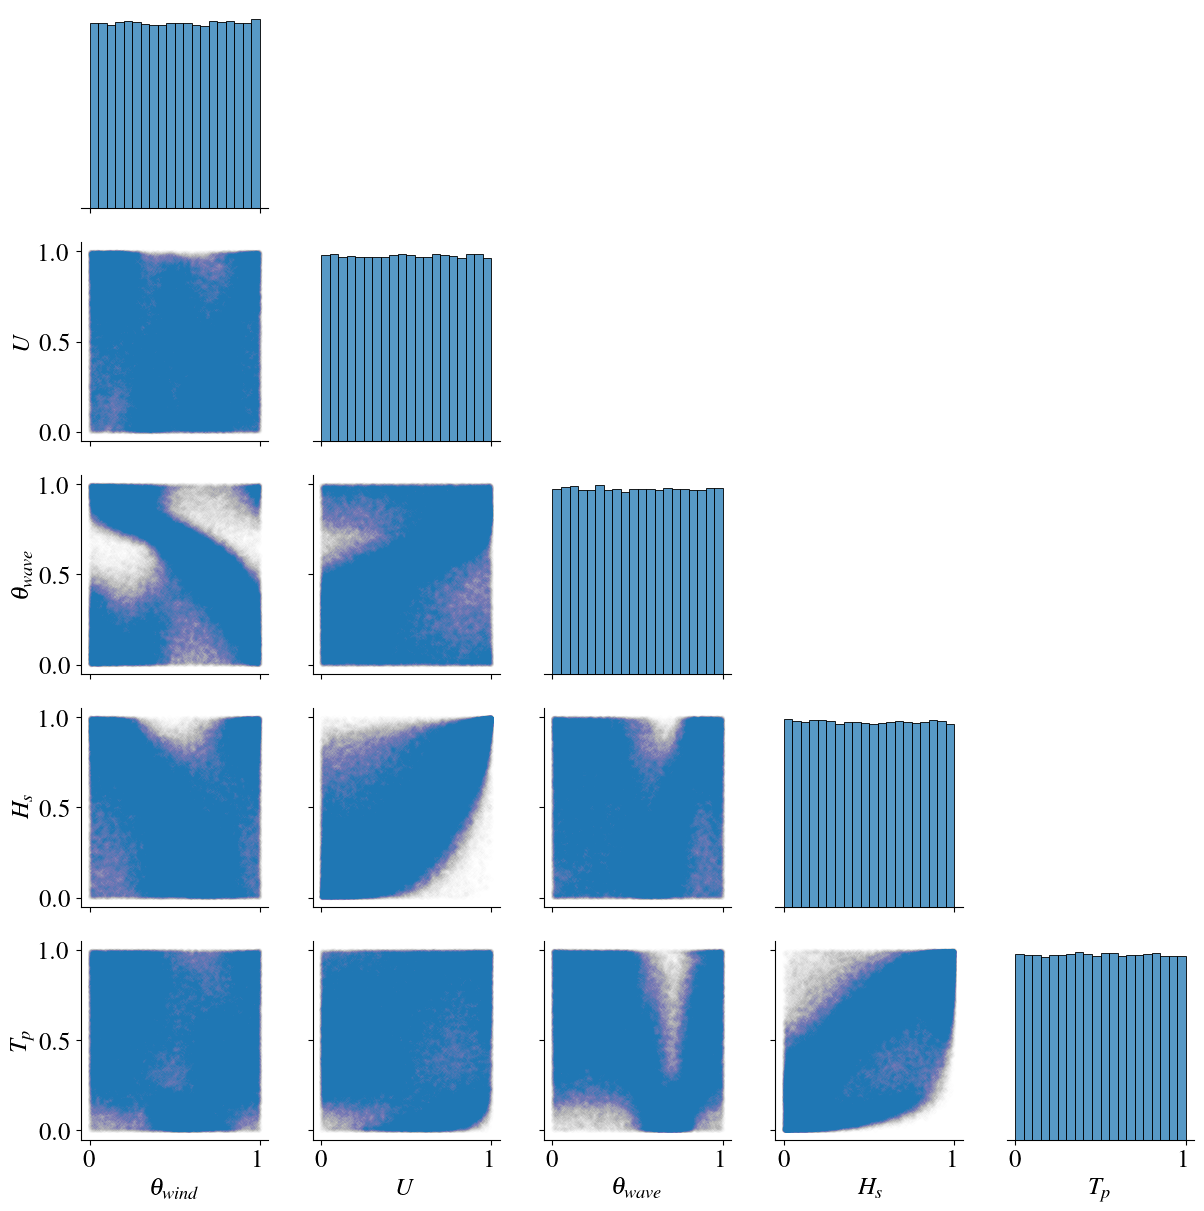

In [18]:
g = sns.PairGrid(berstein_sample, corner=True, hue_kws={"alpha": [alpha], "marker": ["."]})
g = g.map_diag(sns.histplot, bins=20, color='C0')
g = g.map_lower(plt.scatter, color='C0')
g.savefig('figures/ranked_bernstein_simulated.jpg', dpi=300);

Note that this pairplot on a generated sample is close to the data pairplot in the rank space.

## Composing the joint distribution

A multivariate distribution is defined by marginals and a copula.

In [19]:
X = ot.ComposedDistribution([WindDir_kde, U_dist, WaveDir_kde, Hs_dist, Tp_kde], bernstein_copula)
X_sample = X.getSample(N)
joint_df = pd.DataFrame(np.array(X_sample), columns=new_columns)

WRN - Warning! The description of the distribution ComposedDistribution is [v0,X0,v0,X0,v0] and cannot identify uniquely the marginal distribution. Use default description instead.


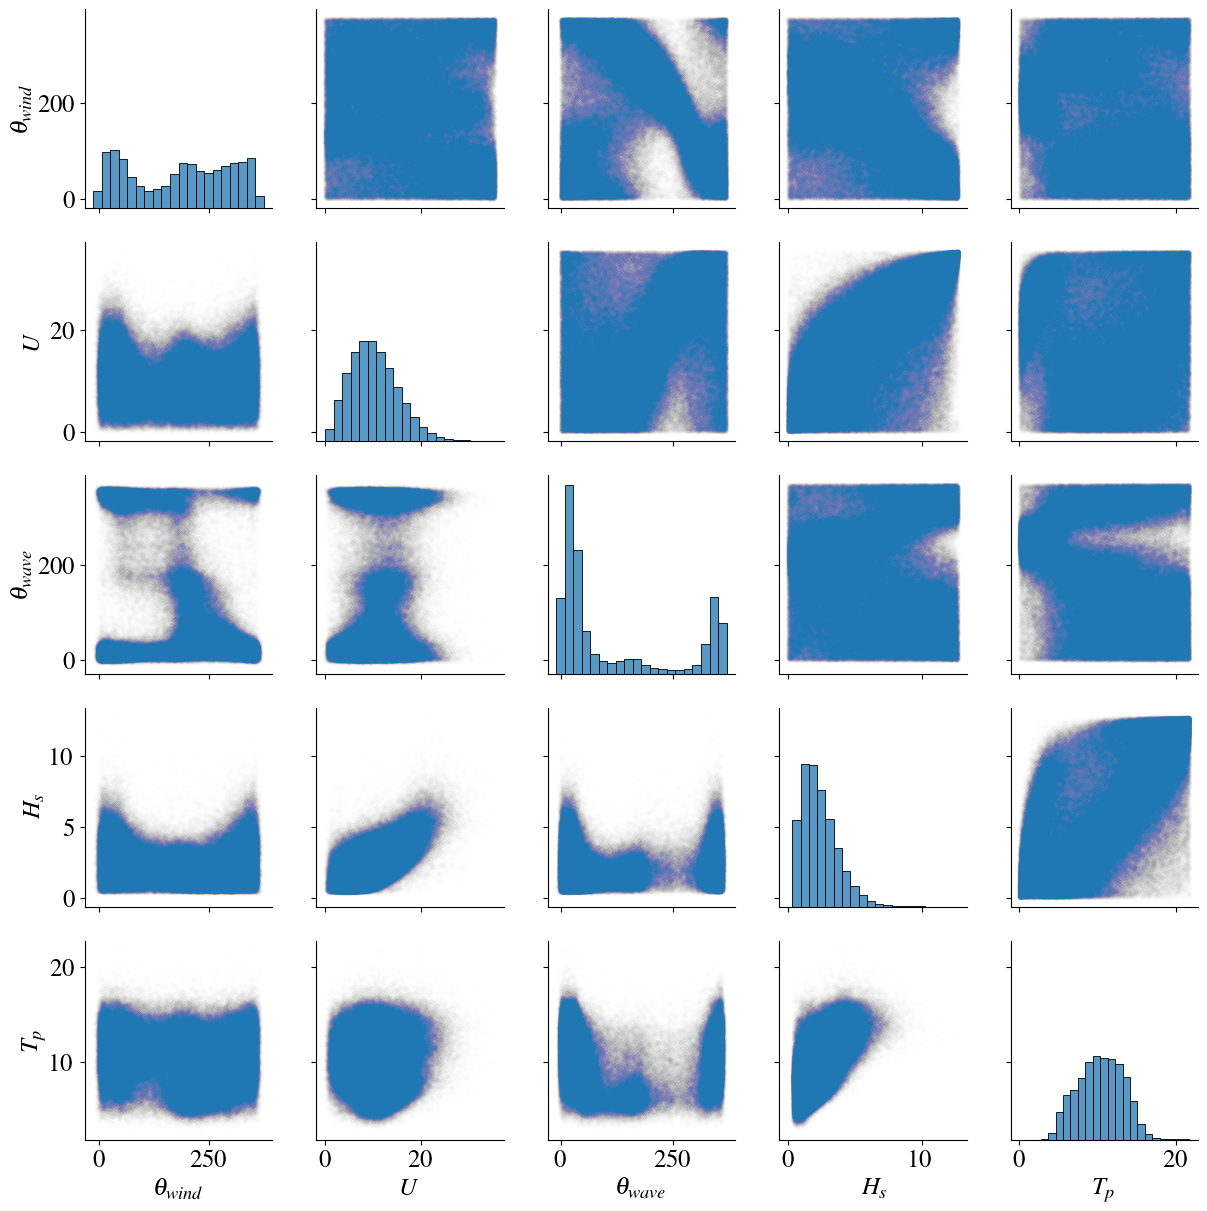

In [20]:
g = sns.PairGrid(joint_df, hue_kws={"alpha": [alpha], "marker": ["."]})
g = g.map_diag(sns.histplot, bins=20, color='C0')
g = g.map_lower(plt.scatter, color='C0')
g.data = joint_df.rank() / N * joint_df.max().values
g = g.map_upper(plt.scatter, color='C0')
g.savefig('figures/simulated_data.jpg', dpi=300);